In [63]:
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#movie = 'Control'
#movie = '130721'
#movie ='140721'
#movie ='150721'
#movie ='100621'
#movie = '130721_CCA60_RAW'
movie = '280523 AM100 568'

MOVIE_PATH = DATA_PATH + movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.filters import gaussian
from tqdm.notebook import trange, tqdm
import pandas as pd
from objects import movie_structure
from objects.movie_structure import gaussian_curvature, mean_curvature

from preprocessing import preprocessing
import importlib
import seaborn as sns




In [64]:
gel = np.load(MOVIE_PATH +'np/gel_norm.npy', mmap_mode='r')
motors = np.load(MOVIE_PATH +'np/motors_transformed.npy', mmap_mode='r')

In [45]:
surface = np.load(MOVIE_PATH + 'np/height.npy') -np.load(MOVIE_PATH + 'np/membrane.npy')

mean_list = []
std_list = []
fluctations_list = []

for t in range(len(surface)):
    mean_list.append(np.nanmean(surface[t]))
    std_list.append(np.nanstd(surface[t]))
    fluctations_list.append(np.nanmean((surface[t] - np.nanmean(surface[t]))**2))
pd.DataFrame({'mean':mean_list, 'std':std_list, 'fluctations':fluctations_list}).to_csv(MOVIE_PATH +'np/' + movie+ 'surface_stats.csv')


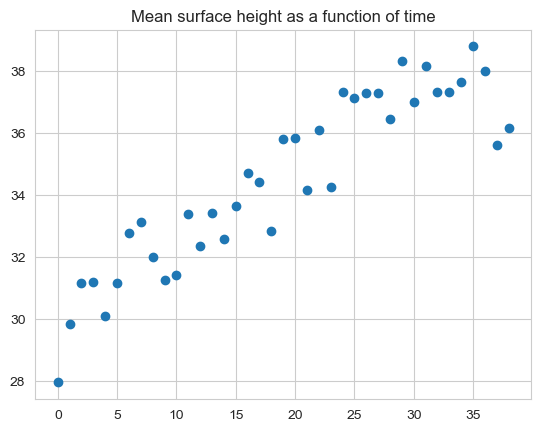

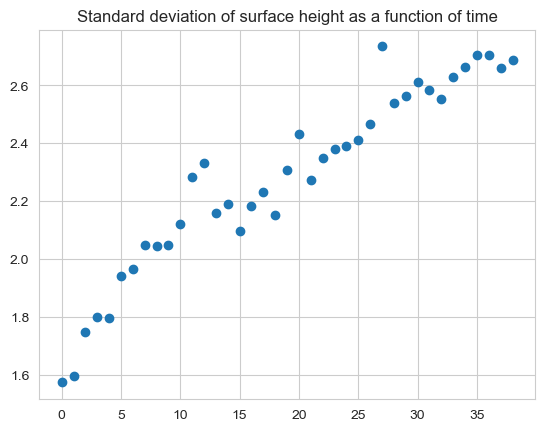

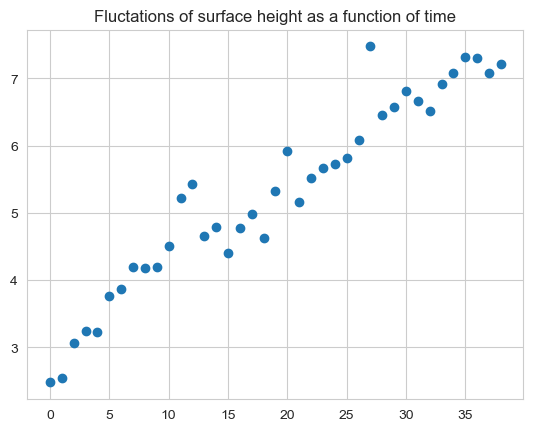

In [46]:
plt.scatter(range(len(mean_list)), mean_list)
plt.title('Mean surface height as a function of time')
plt.show()
plt.scatter(range(len(std_list)), std_list)
plt.title('Standard deviation of surface height as a function of time')
plt.show()
plt.scatter(range(len(fluctations_list)), fluctations_list)
plt.title('Fluctations of surface height as a function of time')
plt.show()


## <span color=red> motors and intensity distribution </span>


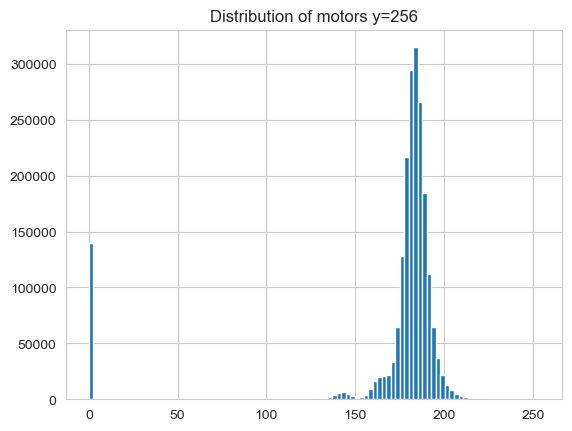

In [77]:
y = 256
data = motors[:,:,y,:]
data = data[~np.isnan(data)]
plt.hist(data.flatten(), bins=100)
plt.title('Distribution of motors y=%d'%y)
plt.show()
np.savetxt(GRAPH_PATH + 'distribution\motors_y=%d'%y + movie + '.csv', data.flatten(), delimiter=',')

In [66]:

channel_name= ['Gel', 'Motors']
manifold_name = ['Membrane', 'Surface']
channel = 0
manifold = 0


In [67]:
membrane = np.load(MOVIE_PATH + 'np/membrane.npy')
surface = np.load(MOVIE_PATH + 'np/height.npy')
membrane_mask = ~np.isnan(membrane)
surface_mask = ~np.isnan(surface)

membrane[np.isnan(membrane)] = 0
surface[np.isnan(surface)] = 0
membrane = membrane.astype(int)
surface = surface.astype(int)
def values_3d(data, manifold):
    index_a = np.arange(data.shape[0])[:, np.newaxis, np.newaxis]
    index_c = np.arange(data.shape[2])[:, np.newaxis]
    index_d = np.arange(data.shape[3])


# Use advanced indexing to get the required values from `motors`
    return data[index_a, manifold, index_c, index_d]



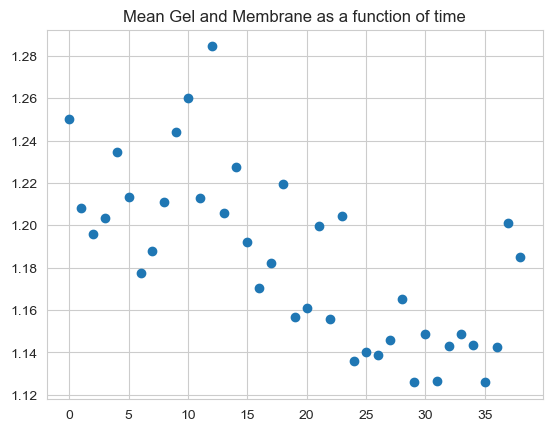

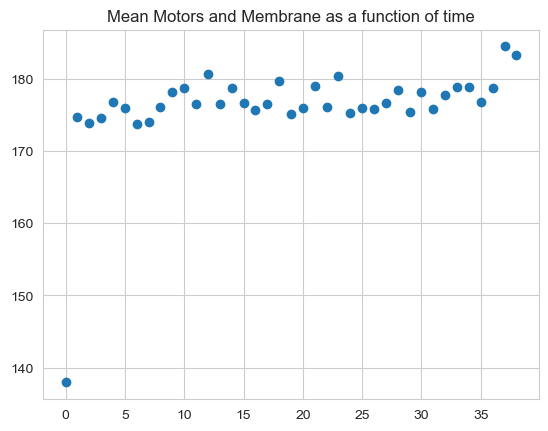

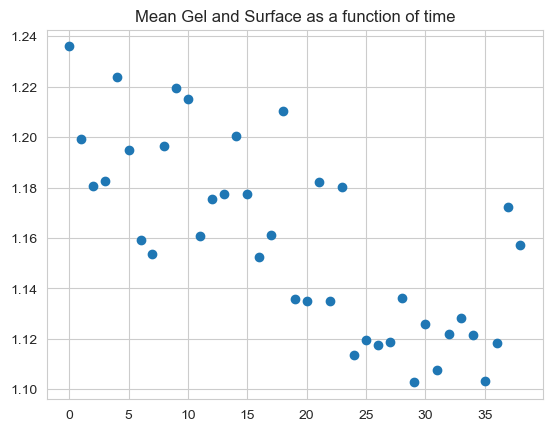

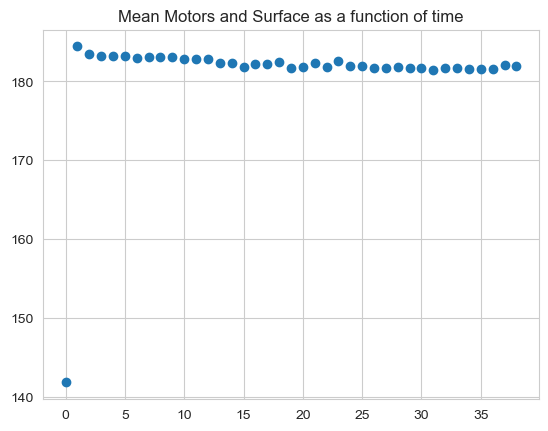

In [76]:
for m_index, manifold in enumerate([membrane+3, surface-2]):
    for e_index ,experiment_data in enumerate([gel,motors]):

        data = values_3d(experiment_data, manifold)
        data [~np.bitwise_and(membrane_mask, surface_mask)]= np.nan

        label = channel_name[e_index] + ' and ' + manifold_name[m_index ]
        mean = np.nanmean(data, axis=(1,2))
        plt.scatter(range(len(mean)), mean)
        np.savetxt(GRAPH_PATH + 'distribution\%s_mean'%label + movie + '.csv', mean, delimiter=',')
        plt.title('Mean %s as a function of time'%label)
        plt.savefig(GRAPH_PATH + 'distribution\%s_mean'%label + movie + '.png')
        plt.show()


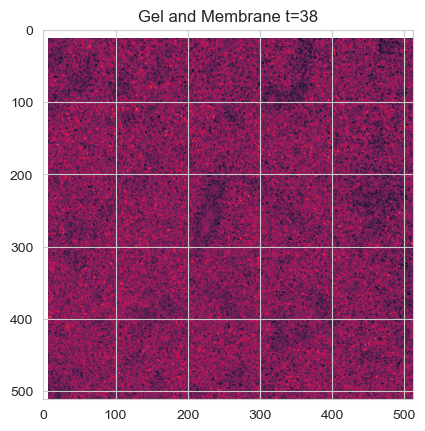

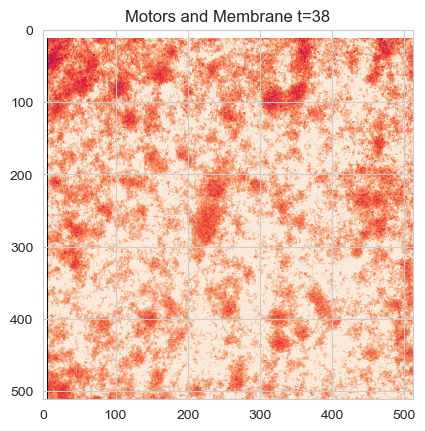

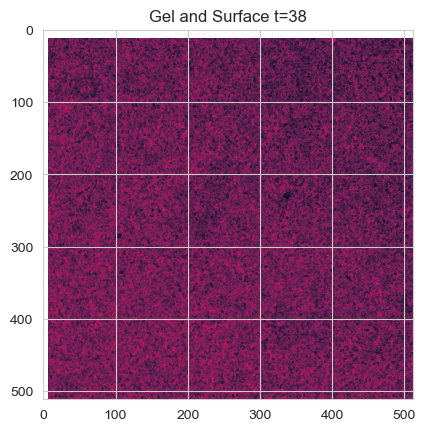

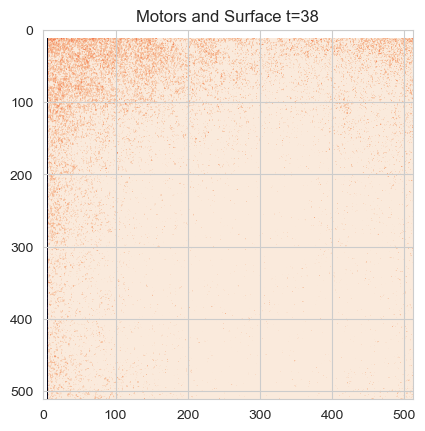

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

# Create random 3D array with dimensions (time, x, y)

for m_index, manifold in enumerate([membrane+3, surface-2]):
    for e_index ,experiment_data in enumerate([gel,motors]):

        data = values_3d(experiment_data, manifold)
        data [~np.bitwise_and(membrane_mask, surface_mask)]= np.nan

        label = channel_name[e_index] + ' and ' + manifold_name[m_index ]

        # Initialize the plot
        fig, ax = plt.subplots()
        im = ax.imshow(data[0, :, :], animated=True)

        def update(frame):
            # Update the imshow data at each frame
            im.set_array(data[frame, :, :])
            #set title
            ax.set_title('%s t=%d'%(label,frame))
            return [im]

        # Create the animation
        ani = FuncAnimation(fig, update, frames=range(len(data)), blit=True, interval=1000     )
        writer = animation.FFMpegWriter(fps=1)

        ani.save(GRAPH_PATH + 'distribution\%s_heatmap'%label + movie + '.mp4', writer=writer)

        plt.show()
